<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/CNN2_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fef61479-5a57-3c83-a1dd-e322786de91e)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.8.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Load the pretrained model (only the feature extractor)

In [ ]:
# Load the ImageNet VGG-16 model, ***excluding*** the latter part regarding the classifier
# Default of input_shape is 224x224x3 for VGG-16
img_w,img_h = 32,32     # image size of CIFAR-10
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

# 3. Prepare our dataset

In [ ]:
# Load CIFAR-10 color image dataset
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

# Inspect the dataset
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

170508288/170498071 [==============================] - 2s 0us/step
x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(50000, 32, 32, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(50000, 1) , min=[0] , max=[9]
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(10000, 32, 32, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(10000, 1) , min=[0] , max=[9]


In [ ]:
print(x_train.shape)

(50000, 32, 32, 3)


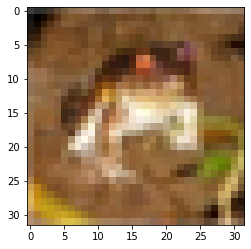

In [ ]:
plt.imshow(x_train[0])

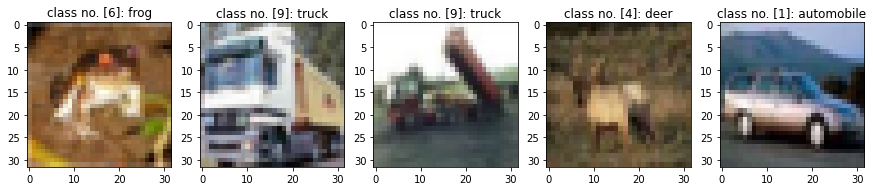

In [ ]:
cifar10_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Visualize the first five images in x_train
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_train[i]}: {cifar10_labels[ int(y_train[i]) ]}" )                
    plt.imshow( x_train[i] )
    #plt.axis( "off" )        
plt.show()

In [ ]:
print(x_train)

In [ ]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirements
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

float32 (50000, 32, 32, 3) -123.68 151.061
float32 (10000, 32, 32, 3) -123.68 151.061


# 4. Prepare for transfer learning and finetuning

- Add the new classification head
- Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [ ]:
# Access a layer by its 0-based index
a = vgg_extractor.layers[3]   
print( f"Layer {a}: name = {a.name} , trainable = {a.trainable}" )

# Access a layer by its name
b = vgg_extractor.get_layer('block5_conv1') 
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )
b.trainable = False       # freeze this layer

Layer <keras.layers.pooling.MaxPooling2D object at 0x7f15c1309450>: name = block1_pool , trainable = True
Layer <keras.layers.convolutional.Conv2D object at 0x7f15c02172d0>: name = block5_conv1 , trainable = True


In [ ]:
# Iterate over all layers in the model
for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = True
Layer 1: name = block1_conv1 , trainable = True
Layer 2: name = block1_conv2 , trainable = True
Layer 3: name = block1_pool , trainable = True
Layer 4: name = block2_conv1 , trainable = True
Layer 5: name = block2_conv2 , trainable = True
Layer 6: name = block2_pool , trainable = True
Layer 7: name = block3_conv1 , trainable = True
Layer 8: name = block3_conv2 , trainable = True
Layer 9: name = block3_conv3 , trainable = True
Layer 10: name = block3_pool , trainable = True
Layer 11: name = block4_conv1 , trainable = True
Layer 12: name = block4_conv2 , trainable = True
Layer 13: name = block4_conv3 , trainable = True
Layer 14: name = block4_pool , trainable = True
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = True
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True


In [ ]:
# Recursively freeze all layers in the model
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


## 4.2 Add a new classification head

In [ ]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] ) 

In [ ]:
history = model.fit( x_train_vgg, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )

Epoch 1/20
313/313 [==============================] - 28s 51ms/step - loss: 3.4616 - acc: 0.4683 - val_loss: 1.2125 - val_acc: 0.5945
Epoch 2/20
313/313 [==============================] - 17s 54ms/step - loss: 1.2633 - acc: 0.5763 - val_loss: 1.0976 - val_acc: 0.6226
Epoch 3/20
313/313 [==============================] - 14s 46ms/step - loss: 1.0906 - acc: 0.6255 - val_loss: 1.0533 - val_acc: 0.6420
Epoch 4/20
313/313 [==============================] - 14s 46ms/step - loss: 1.0008 - acc: 0.6529 - val_loss: 1.0452 - val_acc: 0.6473
Epoch 5/20
313/313 [==============================] - 14s 46ms/step - loss: 0.9297 - acc: 0.6755 - val_loss: 1.0190 - val_acc: 0.6595
Epoch 6/20
313/313 [==============================] - 15s 47ms/step - loss: 0.8824 - acc: 0.6879 - val_loss: 1.0242 - val_acc: 0.6617
Epoch 7/20
313/313 [==============================] - 14s 46ms/step - loss: 0.8463 - acc: 0.7026 - val_loss: 1.0185 - val_acc: 0.6627
Epoch 8/20
313/313 [==============================] - 15s 46ms

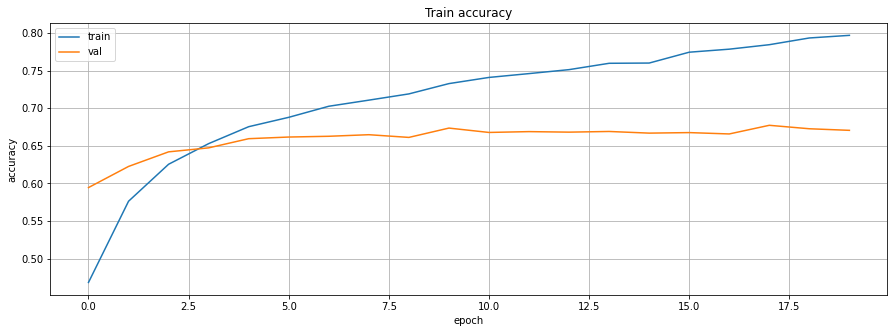

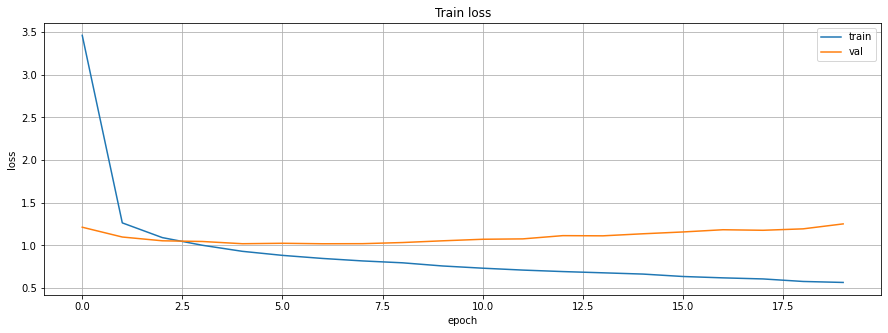

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 6. Evaluate the model on test set

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test_vgg, y_test, batch_size=128)
print( f"{model.metrics_names}: {results}" )

79/79 [==============================] - 3s 37ms/step - loss: 1.2698 - acc: 0.6664
['loss', 'acc']: [1.269750714302063, 0.6664000153541565]


# 7. Inference

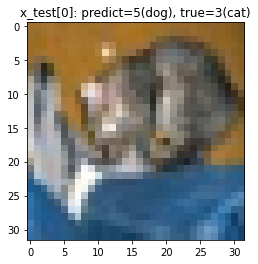

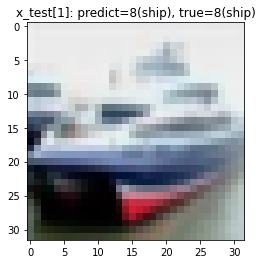

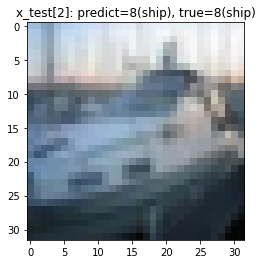

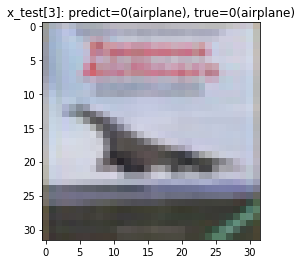

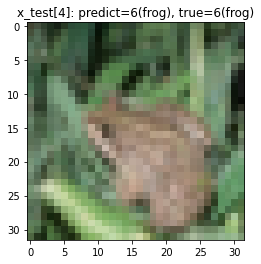

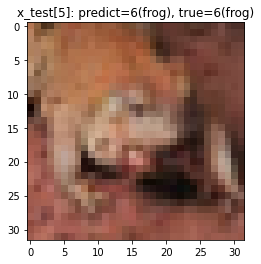

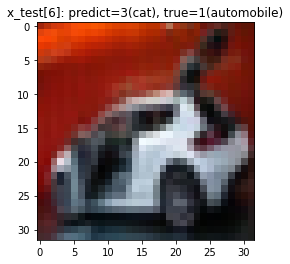

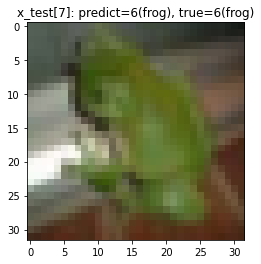

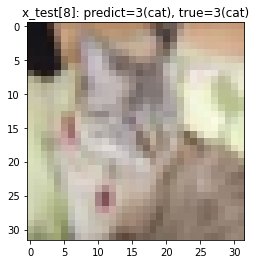

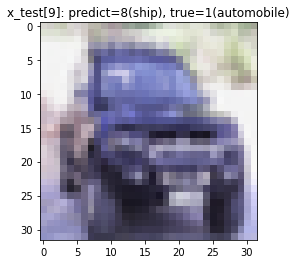

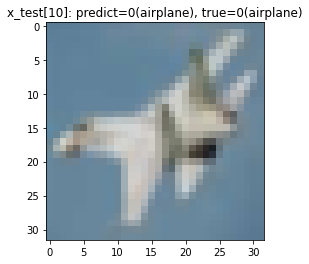

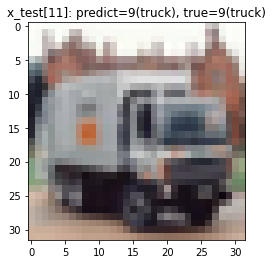

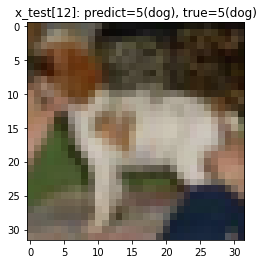

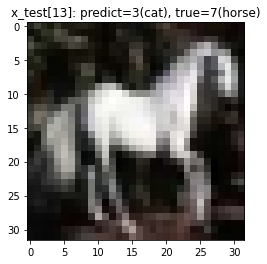

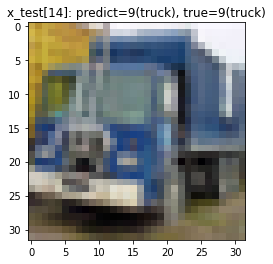

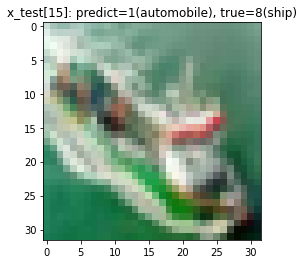

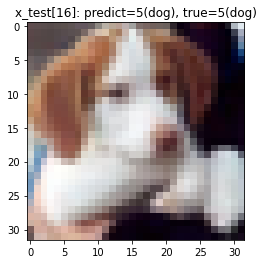

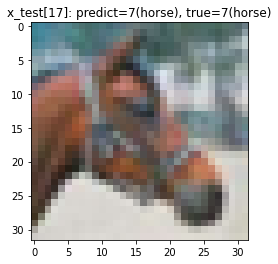

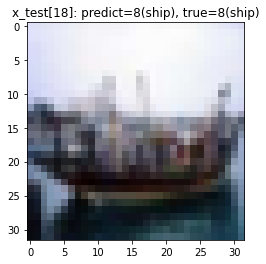

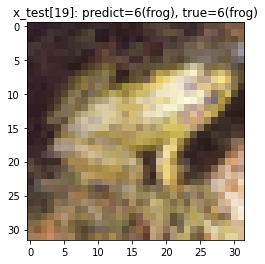

In [ ]:
# Test using the model on the first 20 images in x_test
for i in range(20):
  y_pred = model.predict( x_test_vgg[i].reshape(1,32,32,3) )

  plt.imshow( x_test[i] )
  plt.title( f"x_test[{i}]: predict={np.argmax(y_pred)}({cifar10_labels[np.argmax(y_pred)]}), true={y_test[i][0]}({cifar10_labels[int(y_test[i])]})" )
  plt.show()